In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
tf.random.set_seed(123)
np.random.seed(123)

In [10]:
df = pd.read_csv(r'\Data\Metro_Interstate_Traffic_Volume.csv')

In [11]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [12]:
df.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


In [13]:
df.drop_duplicates(subset=['date_time'], keep=False,inplace=True)

In [14]:
validate = df['traffic_volume'].tail(10)
df.drop(df['traffic_volume'].tail(10).index,inplace=True)

In [15]:
uni_data = df['traffic_volume']
uni_data.index = df['date_time']
uni_data.head()

date_time
2012-10-02 09:00:00    5545
2012-10-02 10:00:00    4516
2012-10-02 11:00:00    4767
2012-10-02 12:00:00    5026
2012-10-02 13:00:00    4918
Name: traffic_volume, dtype: int64

In [16]:
uni_data = uni_data.values
scaler_x = preprocessing.MinMaxScaler()
x_rescaled = scaler_x.fit_transform(uni_data.reshape(-1, 1))

In [17]:
def custom_ts_univariate_data_prep(dataset, start, end, window, horizon):
  X = []
  y = []

  start = start + window
  if end is None:
    end = len(dataset) - horizon

  for i in range(start, end):
    indicesx = range(i-window, i)
    X.append(np.reshape(dataset[indicesx], (window, 1)))
    indicesy = range(i,i+horizon)
    y.append(dataset[indicesy])
  return np.array(X), np.array(y)

In [18]:
univar_hist_window = 48
horizon = 10
TRAIN_SPLIT = 30000
x_train_uni, y_train_uni = custom_ts_univariate_data_prep(x_rescaled, 0, TRAIN_SPLIT,univar_hist_window, horizon)
x_val_uni, y_val_uni = custom_ts_univariate_data_prep(x_rescaled, TRAIN_SPLIT, None,univar_hist_window,horizon)

In [19]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target horizon')
print (y_train_uni[0])

Single window of past history
[[0.76167582]
 [0.62032967]
 [0.65480769]
 [0.69038462]
 [0.67554945]
 [0.71167582]
 [0.76703297]
 [0.82623626]
 [0.79546703]
 [0.65521978]
 [0.48612637]
 [0.38241758]
 [0.32431319]
 [0.21002747]
 [0.13228022]
 [0.06950549]
 [0.04409341]
 [0.0375    ]
 [0.05041209]
 [0.11181319]
 [0.37335165]
 [0.77925824]
 [0.89436813]
 [0.75151099]
 [0.70013736]
 [0.67129121]
 [0.7331044 ]
 [0.78186813]
 [0.84299451]
 [0.63502747]
 [0.49326923]
 [0.39807692]
 [0.36222527]
 [0.24409341]
 [0.13942308]
 [0.08214286]
 [0.05068681]
 [0.04285714]
 [0.05041209]
 [0.1146978 ]
 [0.37445055]
 [0.78145604]
 [0.96016484]
 [0.82211538]
 [0.72925824]
 [0.63228022]
 [0.67087912]
 [0.7010989 ]]

 Target horizon
[[0.71126374]
 [0.75563187]
 [0.78475275]
 [0.86428571]
 [0.83200549]
 [0.67403846]
 [0.48118132]
 [0.41717033]
 [0.38763736]
 [0.27362637]]


In [21]:
BATCH_SIZE = 256
BUFFER_SIZE = 150

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [22]:
GRU_model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(100, input_shape=x_train_uni.shape[-2:],return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(units=50,return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=horizon),
])
GRU_model.compile(optimizer='adam', loss='mse')


In [29]:
model_path = r'G:\Study and WorkRelated\Book Proposal\book\Code and Data\Section 3\Chapter 5\GRU_Univarient_1.h5'

In [30]:
EVALUATION_INTERVAL = 100
EPOCHS = 150
history = GRU_model.fit(train_univariate, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_univariate, validation_steps=50,verbose =1,
                              callbacks =[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Train for 100 steps, validate for 50 steps
Epoch 1/150
100/100 [==============================] - 2s 16ms/step - loss: 0.0277 - val_loss: 0.0240
Epoch 2/150
100/100 [==============================] - 2s 15ms/step - loss: 0.0270 - val_loss: 0.0249
Epoch 3/150
100/100 [==============================] - 1s 15ms/step - loss: 0.0278 - val_loss: 0.0267
Epoch 4/150
100/100 [==============================] - 2s 15ms/step - loss: 0.0241 - val_loss: 0.0245
Epoch 5/150
100/100 [==============================] - 1s 15ms/step - loss: 0.0271 - val_loss: 0.0251
Epoch 6/150
100/100 [==============================] - 2s 15ms/step - loss: 0.0254 - val_loss: 0.0247
Epoch 7/150
100/100 [==============================] - 2s 16ms/step - loss: 0.0258 - val_loss: 0.0237
Epoch 8/150
100/100 [==============================] - 2s 15ms/step - loss: 0.0265 - val_loss: 0.0240
Epoch 9/150
100/100 [==============================] - 1s 15ms/step - loss: 0.0261 - val_loss: 0.0246
Epoch 10/150
100/100 [=================

In [31]:
# Recreate the exact same model, including its weights and the optimizer
Trained_model = tf.keras.models.load_model(model_path)

In [32]:
# Show the model architecture
Trained_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 48, 100)           30900     
_________________________________________________________________
dropout (Dropout)            (None, 48, 100)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 50)                22800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                510       
Total params: 54,210
Trainable params: 54,210
Non-trainable params: 0
_________________________________________________________________


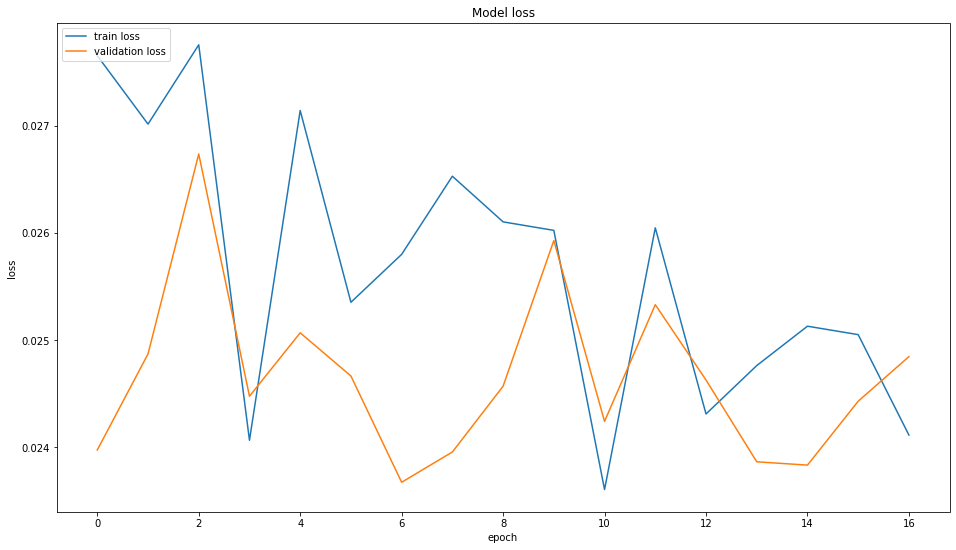

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [37]:
uni = df['traffic_volume']
validatehori = uni.tail(48)

In [38]:
validatehist = validatehori.values
scaler_val = preprocessing.MinMaxScaler()
val_rescaled = scaler_x.fit_transform(validatehist.reshape(-1, 1))

In [39]:
val_rescaled = val_rescaled.reshape((1, val_rescaled.shape[0], 1))

In [40]:
Predicted_results = Trained_model.predict(val_rescaled)

In [41]:
Predicted_results

array([[0.60907274, 0.5980475 , 0.5873754 , 0.5756924 , 0.55768406,
        0.531145  , 0.50104624, 0.46705398, 0.4160539 , 0.34934813]],
      dtype=float32)

In [42]:
Predicted_inver_res = scaler_x.inverse_transform(Predicted_results)

In [43]:
Predicted_inver_res

array([[3899.9028, 3835.3718, 3772.9082, 3704.5276, 3599.1248, 3443.7915,
        3267.6235, 3068.667 , 2770.1633, 2379.7346]], dtype=float32)

In [45]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [46]:
timeseries_evaluation_metrics_func(validate,Predicted_inver_res[0])

Evaluation metric results:-
MSE is : 619999.1210417807
MAE is : 676.7561767578125
RMSE is : 787.4002292619559
MAPE is : 36.159127199964715
R2 is : 0.5974872384337513



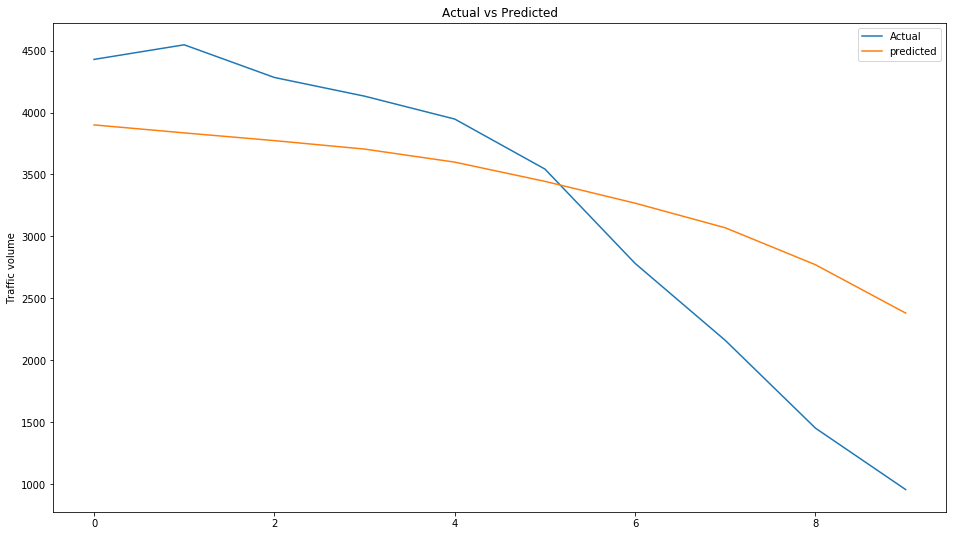

In [47]:
plt.plot( list(validate))
plt.plot( list(Predicted_inver_res[0]))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()